In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

  Using cached ipywidgets-8.0.4-py3-none-any.whl (137 kB)
  Using cached widgetsnbextension-4.0.5-py3-none-any.whl (2.0 MB)
  Using cached jupyterlab_widgets-3.0.5-py3-none-any.whl (384 kB)



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [22]:
def read_image(path):
  # TODO: Open the image in RGB format and convert into numpy array
  image = Image.open(path).convert('RGB')
  image = np.asarray(image)
  
  # TODO: Normalize the image
  image = image/255
  return image

In [20]:
image = read_image('image.png')
# TODO: Get shape of image
image.shape

(382, 774, 3)

In [23]:
original_bytes = image.nbytes
print ("The space (in bytes) needed to store this image is", original_bytes)

The space (in bytes) needed to store this image is 7096032


In [24]:
def SVD_channels(image):
  # TODO: Separate the channels of the image
  image_red = image[:, :, 0]
  image_green = image[:, :, 1]
  image_blue = image[:, :, 2]

  # Perform SVD on each channel
  U_r, S_r, V_r = np.linalg.svd(image_red, full_matrices=True)
  U_g, S_g, V_g = np.linalg.svd(image_green, full_matrices=True)
  U_b, S_b, V_b = np.linalg.svd(image_blue, full_matrices=True)
  
  return U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b


In [25]:
U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)
bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b]])
print ("The matrices that we store have total size (in bytes):", bytes_to_be_stored)

# Before it was just an image, then we have 3 matrices, red, blue and green so became 70MB
# Now is 17MB because for each red, green and blue, we split into U, V and sigma

The matrices that we store have total size (in bytes): 17889168


In [26]:
def TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k):
  # TODO: Use only top K eignevectors. Top K in U, S, V in all channels

  U_r_k = U_r[:, 0:k]
  V_r_k = V_r[0:k, :]
  U_g_k = U_g[:, 0:k]
  V_g_k = V_g[0:k, :]
  U_b_k = U_b[:, 0:k]
  V_b_k = V_b[0:k, :]

  S_r_k = S_r[0:k]
  S_g_k = S_g[0:k]
  S_b_k = S_b[0:k]

  return U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k


In [27]:
U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k=50)

compressed_bytes = sum([matrix.nbytes for matrix in [U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k]])
print ("The compressed matrices that we store now have total size (in bytes):", compressed_bytes)

The compressed matrices that we store now have total size (in bytes): 1388400


In [28]:
ratio = compressed_bytes / original_bytes
print ("The compression ratio between the original image size and the total size of the compressed factors is", ratio)

The compression ratio between the original image size and the total size of the compressed factors is 0.19565864415493053


In [31]:
def reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k):
  # TODO: Reconstruct the image from compressed U, S, V matrices.

  image_red_approx = np.dot(U_r_k, np.dot(np.diag(S_r_k), V_r_k))
  image_green_approx = np.dot(U_g_k, np.dot(np.diag(S_g_k), V_g_k))
  image_blue_approx = np.dot(U_b_k, np.dot(np.diag(S_b_k), V_b_k))

  image_approx = np.zeros((382, 774, 3))

  image_approx[:, :, 0] = image_red_approx
  image_approx[:, :, 1] = image_green_approx
  image_approx[:, :, 2] = image_blue_approx

  return image_approx


In [32]:
image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

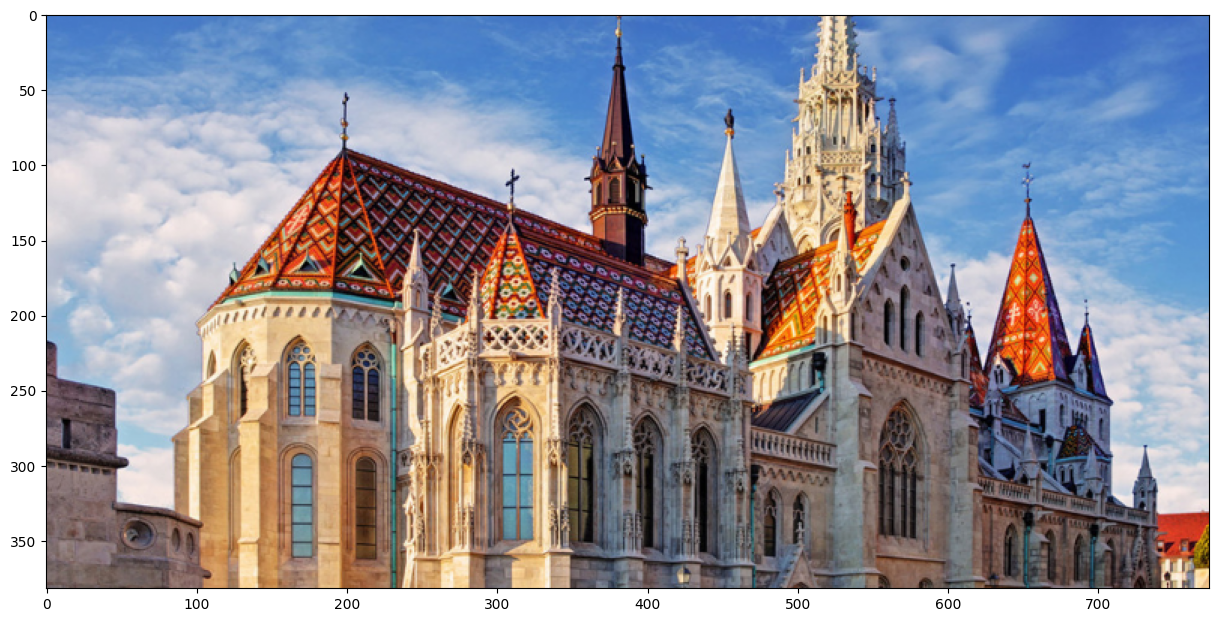

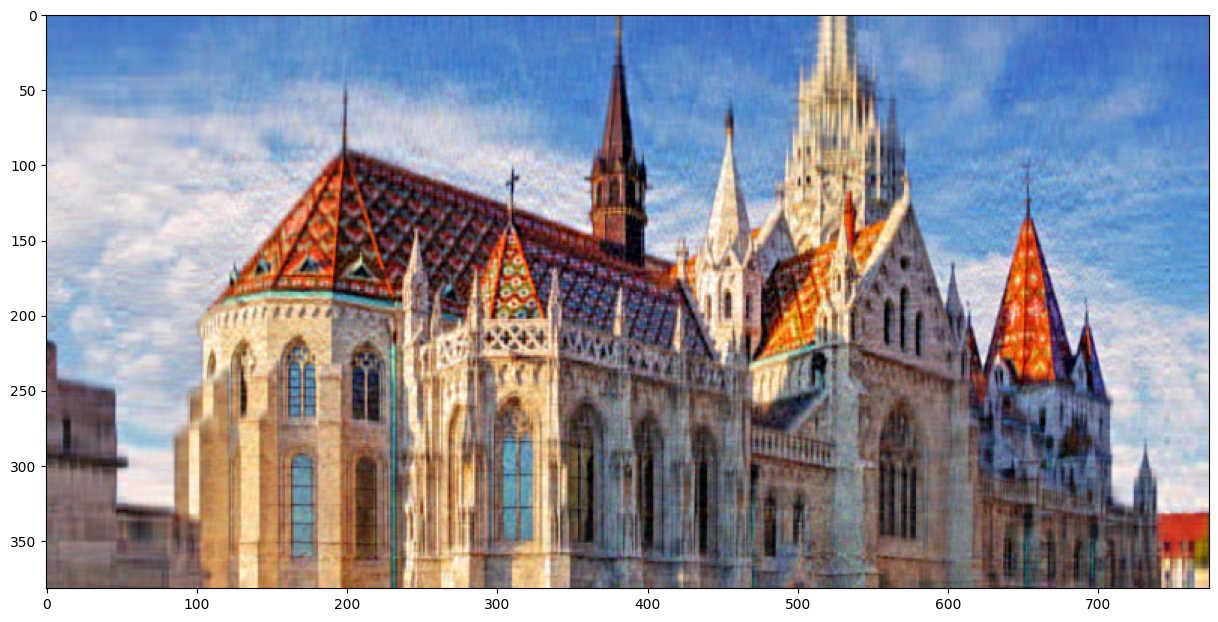

In [33]:
# fig = plt.figure(figsize=(15, 10))
# a = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.figure(figsize=(15, 10))
plt.imshow(image_reconstructed)
# a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
# plt.show()

In [38]:
@interact(k=widgets.IntSlider(min=0, max=382, step=2))
def image_compressor(k):
  image = read_image('image.png')
  U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)

  U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k)

  image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

  image_reconstructed[image_reconstructed < 0] = 0
  image_reconstructed[image_reconstructed > 1] = 1

  plt.figure(figsize=(15, 10))

  plt.imshow(image_reconstructed)

# interact(image_compressor);

# Number of eigenvectors is min of the shape, so in this case is 382. So, original image is obtained when k = 382

interactive(children=(IntSlider(value=0, description='k', max=382, step=2), Output()), _dom_classes=('widget-i…